In [494]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

xTrain = np.loadtxt("traindata.csv", delimiter =',')
yTrain = np.loadtxt("trainlabel.csv", delimiter =',')
xValid = np.loadtxt("validdata.csv", delimiter =',')
yValid = np.loadtxt("validlabel.csv", delimiter =',')

#Choose parameters 
epochs = 16
learning_rate = 0.1
afunction = "relu" #(other options: "relu","sigmoid")
seed = 2

In [495]:
class SNC(object):  
    def __init__(self, epochs, learning_rate, afunction):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.afunction = afunction 
        
        self.avgLoss = []
        self.accuRacy = []
        
        self.avgvLoss = []
        self.vaccuRacy = []
        
        
        self.store = {} #dictionary to keep track of changing z (sum), ypred (activate),ypredfinal (decision)
        
    def getWeights(self):
        np.random.seed(seed) #SEED!!!
        self.store["wi"] = np.random.uniform(0,1, (9,1)) 
        self.store["b"] = np.random.uniform()
        self.old_w = [np.reshape(self.store["wi"],9)]
        self.old_b = [self.store["b"]]
        
        return self.store["wi"], self.store["b"] 
     
    def lossMSE(self,ypred,y):
        ypred1=ypred.reshape(np.size(y)) #(200)
        l = np.square(ypred1 - y) #(200)
        return l     
    def accuracy(self,ypredfinal,y):
        ypredfinal1 = ypredfinal.reshape(np.size(y)) #(200)
        accuracy = sum(y == ypredfinal1) / len(y) * 100 
        return accuracy  
    
    def relu(self,x):
        return np.maximum(0,x) 
    def sigmoid(self,x):
        return (1.0/(1.0 + np.exp(-x)))    
    def activation(self,z):
        if self.afunction == "linear":
            return z
        elif self.afunction == "relu":
            return np.maximum(0,z)
        elif self.afunction == "sigmoid":
            return (1.0/(1.0 + np.exp(-z))) 
   
    def forward(self): #repeat for every training example ############################# 
        #SUM WEIGHTS 
        Z = self.x.dot(self.store["wi"]) + self.store["b"] 
        self.store["Z"] = Z #(200,1)
        
        #ACTIVATE
        ypred = self.activation(Z)  #(200,1)   
        self.store['ypred'] = ypred #(200,1)
        
        #DECISION FUNCTION 
        ypredfinal = np.zeros((len(ypred),1)) #(200,1)
        for i in range(len(ypred)):
            if ypred[i] >= 0.5:   
                ypredfinal[i] =  1
            elif ypred[i] <0.5:
                ypredfinal[i] = 0 
        self.store['ypredfinal'] = ypredfinal #(200,1)
        
        #CALCULATE LOSS 
        loss = self.lossMSE(ypred, self.y) #(200)
        
        #CALCULATE ACCURACY
        accuracy = self.accuracy(ypredfinal,self.y) #1 for each epoch 
        
        #CALCULATE AVG LOSS
        avgloss = np.sum(loss) / len(loss) #1 avg loss per epoch

        
        return ypred,avgloss,accuracy
    
    def backward(self,ypred): #broadcasting can only happen with (200)
        if self.afunction == "linear":
            ypred1 = (self.store['ypred']).reshape(np.size(self.y)) #ypred1 (200)
            dl_dw = (self.x.T * (2*(ypred1-self.y))).T #(200,9)
            dl_db = 2 * (ypred1 - self.y) #(200)
            avg_dldw = dl_dw.mean(axis=0) #avg over 200, take mean of each column in dl_dw; size = 9 
            avg_dldb = np.mean(dl_db)#avg over 200; an int
        
        elif self.afunction == "relu":
            ypred1 = (self.store['ypred']).reshape(np.size(self.y)) #ypred1 (200)
            dl_dw = (self.x.T * (2*(self.relu(ypred1) - self.y) * np.where(ypred1 >= 0, 1, 0))).T #(200,9)
            dl_db = 2 * (self.relu(ypred) - self.y) * np.where(ypred >= 0, 1, 0) 
            avg_dldw = dl_dw.mean(axis=0) #take mean of each column 
            avg_dldb = np.mean(dl_db)#(1)

        
        elif self.afunction == "sigmoid":
            ypred1 = (self.store['ypred']).reshape(np.size(self.y)) #ypred1 (200)
            dl_dw = (self.x.T * (2*(self.sigmoid(ypred1) - self.y)* self.sigmoid(ypred1)*(1-self.sigmoid(ypred1)))).T
            dl_db = 2*(self.sigmoid(ypred1) - self.y)*(self.sigmoid(ypred1))*(1-self.sigmoid(ypred1)) 
            avg_dldw = dl_dw.mean(axis=0) 
            avg_dldb = np.mean(dl_db)#(1)
        
        #REMEMBER THE OLD WEIGHTS (from every epoch)
        self.old_w = self.old_w + [np.reshape(self.store["wi"],9)] #[[],[],[],[]] 
        self.old_b = self.old_b + [self.store["b"]] #[#,#,#]
        
        #UPDATE WEIGHTS & BIAS                                                  
        self.store["wi"] = np.reshape(self.store["wi"],np.shape(avg_dldw)) - self.learning_rate*avg_dldw #we need the averages
        self.store["b"] = self.store["b"] - self.learning_rate * avg_dldb #the averages 
        
        return avg_dldw, avg_dldb
                                                      
    def train(self, x, y): 
        self.x = x #vector or training examples (200,9)
        self.y = y #(200,1)
        self.getWeights() #initialize weights and bias

        for i in range(self.epochs):
            ypred, avgloss, accuracy = self.forward()  #ypred (200,1), avgloss(1), acc (1)
            
            #ACCUMULATE self.AVGLOSS AND self.ACCURACY
            self.avgLoss = self.avgLoss + [avgloss] #for this epoch
            self.accuRacy = self.accuRacy + [accuracy]
            self.backward(ypred)
            

    def predict(self,x,y): #xValid will be put in (no backwards here)       
        for e in range(self.epochs - 1):
            Z = x.dot(np.reshape(np.array(self.old_w[e]),(9,1))) + self.old_b[e] #(20,1)
            ypred = self.activation(Z)  #(20,1) 
            
            #DECISION FUNCTION 
            ypredfinal = np.zeros((len(ypred),1)) #(20,1)
            for i in range(len(ypred)):
                if ypred[i] >= 0.5:   
                    ypredfinal[i] =  1
                elif ypred[i] <0.5:
                    ypredfinal[i] = 0 
            
            #CALCULATE LOSS 
            vloss = self.lossMSE(ypred, y) #(20)
            
            #CALCULATE ACCURACY
            vaccuracy = self.accuracy(ypredfinal,y) # 1
            
            #CALCULATE AVG LOSS
            avgvloss = np.sum(vloss) / len(vloss) #1 avg loss per epoch
            
            self.avgvLoss = self.avgvLoss + [avgvloss] #for this epoch
            self.vaccuRacy = self.vaccuRacy + [vaccuracy]
             
        return self.avgvLoss, self.vaccuRacy
           
    
    def plot_loss(self):
        plt.plot(self.avgLoss)
        plt.plot(self.avgvLoss)
        plt.xlabel("Epoch")
        plt.ylabel("Loss") 
        plt.title("Training vs. Validation Loss Curve")
        plt.legend(['Training', 'Validation'], loc='upper left')
        plt.show()  
                                                      
    def plot_accuracy(self):
        plt.plot(self.accuRacy)
        plt.plot(self.vaccuRacy)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy") 
        plt.title("Training vs. Validation Accuracy Curve")
        plt.legend(['Training', 'Validation'], loc='upper left')
        plt.show()  
    
    def print_accuracy(self):
        print("Training Accuracy:", self.accuRacy)
        print("Validation Accuracy:", self.vaccuRacy)
        
    def dispKernel(self,kernel, ksize, isize):
        # for normalizing
        kmax = max(kernel)
        kmin = min(kernel)
        spread = kmax - kmin
        # print("max,min",kmax,kmin)
    
        dsize = int(isize / ksize)
        # print("dsize:",dsize)

        a = np.full((isize, isize), 0.0)
        
        # loop through each element of kernel
        for i in range(ksize):
            for j in range(ksize):
                # fill in the image for this kernel element
                basei = i * dsize
                basej = j * dsize
                for k in range(dsize): 
                    for l in range(dsize):
                        a[basei + k][basej + l] = (kernel[(i * ksize) + j] - kmin) / spread

        # print(a)

        x = np.uint8(a * 255)

        # print(x)
        img = Image.fromarray(x, mode='P')
        imshow(img, cmap='Greys_r')
        plt.show()
    
                                                                                                     
                                            

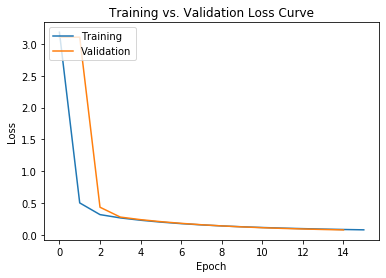

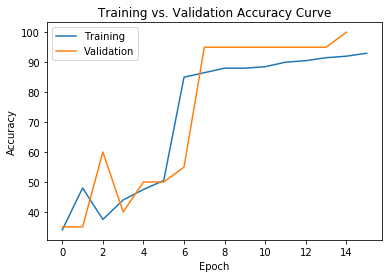

Training Accuracy: [34.0, 48.0, 37.5, 44.0, 47.5, 50.5, 85.0, 86.5, 88.0, 88.0, 88.5, 90.0, 90.5, 91.5, 92.0, 93.0]
Validation Accuracy: [35.0, 35.0, 60.0, 40.0, 50.0, 50.0, 55.00000000000001, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 100.0]


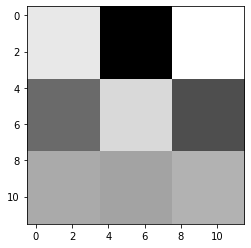

In [496]:
nn = SNC(epochs,learning_rate,afunction)
nn.train(xTrain, yTrain) #train the model
nn.predict(xValid,yValid) #predict on test data
nn.plot_loss()  #need training and validation losses on one graph 
nn.plot_accuracy() #need training and validation accuracies on one graph 
nn.print_accuracy()
nn.dispKernel(nn.store["wi"],3,12)